In [14]:
import torch
import torchvision
import numpy as np
import pandas as pd
import random

In [15]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

# 設定 seed
setup_seed(1234)

### Load Data

In [16]:
# 載入資料集
train_data = pd.read_csv('實驗B/new_train_data.csv')
# 將資料和答案分開
X_train_raw = train_data.drop(columns=["Outcome"])
Y_train_raw = train_data["Outcome"]

test_data = pd.read_csv('實驗B/test_data.csv')
X_test_raw = test_data.drop(columns=["Outcome"])
Y_test_raw = test_data["Outcome"]
# X_train_raw.head()

### Data Normalization

正規化方式 : (data - 平均) / 標準差


In [17]:
# 算平均和標準差
def compute_mu_std(data):
    mu = torch.mean(data, dim=0)
    sigma = torch.std(data, dim=0)
    return mu, sigma


# Z 值
# 算有幾倍標準差
def standard_normalize(data, mu, std):
    data = (data - mu) / std
    return data


# 將資料轉為 Tensor (深度學習用的資料型態)
X_train = torch.tensor(X_train_raw.values, dtype=torch.float)
X_test = torch.tensor(X_test_raw.values, dtype=torch.float)

# 計算標準差
mu, sigma = compute_mu_std(X_train)

# 標準化
X_train = standard_normalize(X_train, mu, sigma)
X_test = standard_normalize(X_test, mu, sigma)

# 轉成一維的 Tensor
Y_train = torch.tensor(Y_train_raw.values).squeeze()
Y_test = torch.tensor(Y_test_raw.values).squeeze()

# IF you are writting YOUR pre-processing, the tensors may have different shape.

### DataLoader

In [18]:
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# 將資料裝成一個一個的 batch
# 因為我們資料太少, 所以 batch size 設定為1
train_dataset = TensorDataset(X_train, Y_train.unsqueeze(dim=1).float())
test_dataset = TensorDataset(X_test, Y_test.unsqueeze(dim=1).float())
train_data = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [19]:
# 計算準確率
# Accuracy, Precision, Recall, F1score
# https://medium.com/@imirene/python%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E5%88%86%E9%A1%9E%E6%A8%A1%E5%9E%8B%E7%9A%845%E5%80%8B%E8%A9%95%E4%BC%B0%E6%8C%87%E6%A8%99-3260f116ce47

def Accuracy(tp, tn, fp, fn):
    return (tp + tn) / (tp + tn + fp + fn) 


def Precision(tp, fp):
    if (tp + fp) == 0:
        return 0
    return tp / (tp + fp)


def Recall(tp, fn):
    if (tp + fn) == 0:
        return 0
    return tp / (tp + fn)


def F1score(tp, fp, fn):
    precision = Precision(tp, fp)
    recall = Recall(tp, fn)
    if (precision + recall) == 0:
        return 0
    return (2 * precision * recall) / (precision + recall)


# 求出 tp, tn, fp, fn
def get_tp_tn_fp_fn(save_output, df_test_ans):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    # 計算 tp, tn, fp, fn
    for i, _ in enumerate(save_output):
        if df_test_ans[i] and save_output[i]:
            tp += 1
        elif not df_test_ans[i] and not save_output[i]:
            tn += 1
        elif df_test_ans[i] and not save_output[i]:
            fn += 1
        else:
            fp += 1
    return tp, tn, fp, fn


def get_result(save_output, df_test_ans):
    tp, tn, fp, fn = get_tp_tn_fp_fn(save_output, df_test_ans)
    return Accuracy(tp, tn, fp, fn), Precision(tp, fp), Recall(tp, fn), F1score(tp, fp, fn)
    

### Train & Test

In [20]:
def train(data, model, criterion, optimizer):
    '''
    Argement:
    data -- iterable data, typr torch.utils.data.Dataloader is prefer
    model -- nn.Module, model contain forward to predict output
    criterion -- loss function, used to evaluate goodness of model
    optimizer -- optmizer function, method for weight updating
    '''
    model.train()
    
    loss_list = []
    total_count = 0
    acc_count = 0
    for x, y in data:
        optimizer.zero_grad()

        # 深度訓練的順序
        # model - 算loss - optimizer
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_count += out.shape[0]
        # 大於 0.5 就算是 1
        # 將答對或錯加到 list
        pred = (out > 0.5)
        acc_count += (pred == y).sum().item()
        loss_list.append(loss.item())
        
    # 算準確率跟 loss
    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

In [21]:
def test(data, model, criterion):
    model.eval()
    
    loss_list = []
    total_count = 0
    acc_count = 0
    
    # 存預測結果 方便後面算各種準確率
    save_output = []
    test_ans = []

    with torch.no_grad():
        for x, y in data:

            out = model(x)
            loss = criterion(out, y)

            total_count += out.shape[0]
            # 大於 0.5 就算是 1
            # 將答對或錯加到 list
            pred = (out > 0.5)

            # 存預測結果
            save_output.append(pred)
            test_ans.append(y)
            
            # 存 loss
            loss_list.append(loss.item())


    
    # 算準確率跟 loss
    loss = sum(loss_list) / len(loss_list)
    # 求各種準確率
    accuracy, precision, recall, flscore = get_result(save_output, test_ans)
    
    return accuracy, loss, precision, recall, flscore

### Model
feature_dim -> 8 -> 1 -> RELU

In [22]:
# Step 2: re-define a model
class TorchMLP(nn.Module):
    def __init__(self, feature_dim):
        '''
        Initiate weights and bias of our model.

        Arguments:
        feature_dim -- int, How many features your data have.
        '''
        super().__init__()

        self.linear1 = nn.Linear(feature_dim, 8)
        self.linear2 = nn.Linear(8, 8)
        self.linear3 = nn.Linear(8, 1)
    
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)

        # Model 架構
        out = self.linear1(x)
        out = self.linear3(out)
        out = F.relu(out)

        # 檢查 output size 對不對
        assert out.shape == torch.Size([x.shape[0], 1]), 'Shape of output is incorrect'

        return out

In [23]:
# 選擇 model, criterion, optimizer

mlp_model = TorchMLP(X_train.shape[1])
criterion = nn.BCEWithLogitsLoss()
params = mlp_model.parameters()

# learning rate 設 0.0001
# lr 算是蠻小的, 一樣是因為資料太少, 所以讓他走慢一點
optimizer = torch.optim.Adam(params, lr=0.0001)

In [24]:
# Training Loop

# train 的 epoch 數
max_epochs = 100
log_interval = 5

# 存各種準確率以及loss的值
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

test_precision_list = []
test_recall_list = []
test_f1score_list = []

# 跑 train
for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = train(train_data, mlp_model, criterion, optimizer)
    # test 額外回傳各種準確率
    test_acc, test_loss, precision, recall, f1score = test(test_data, mlp_model, criterion)

    # 將準確率加入 list
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    test_precision_list.append(precision)
    test_recall_list.append(recall)
    test_f1score_list.append(f1score)
    
    # 印出準確率
    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('Test Acc: {:.6f} Test Loss: {:.6f}'.format(test_acc, test_loss))
        print('Test Precision: {:.6f}'.format(precision))
        print('Test Recall: {:.6f}'.format(recall))
        print('Test F1-score: {:.6f}'.format(f1score))




==================== Epoch 5 ====================
Train Acc: 0.630701 Train Loss: 0.639870
Test Acc: 0.770000 Test Loss: 0.649745
Test Precision: 0.937500
Test Recall: 0.405405
Test F1-score: 0.566038
==================== Epoch 10 ====================
Train Acc: 0.728587 Train Loss: 0.610348
Test Acc: 0.810000 Test Loss: 0.635566
Test Precision: 0.846154
Test Recall: 0.594595
Test F1-score: 0.698413
==================== Epoch 15 ====================
Train Acc: 0.746385 Train Loss: 0.600329
Test Acc: 0.760000 Test Loss: 0.634101
Test Precision: 0.709677
Test Recall: 0.594595
Test F1-score: 0.647059
==================== Epoch 20 ====================
Train Acc: 0.753059 Train Loss: 0.596948
Test Acc: 0.770000 Test Loss: 0.633517
Test Precision: 0.718750
Test Recall: 0.621622
Test F1-score: 0.666667
==================== Epoch 25 ====================
Train Acc: 0.751947 Train Loss: 0.595477
Test Acc: 0.770000 Test Loss: 0.631673
Test Precision: 0.718750
Test Recall: 0.621622
Test F1-score: 

### 實驗A最好的 epoch

In [12]:
# 找出最高的 acc 以及他的 index
# 之後依據這些 index 去查其他數據
best_test_acc = max(test_acc_list)
best_test_acc_index = test_acc_list.index(best_test_acc)

best_train_acc = train_acc_list[best_test_acc_index]
best_train_loss = train_loss_list[best_test_acc_index]
best_test_loss = test_loss_list[best_test_acc_index]

best_precision = test_precision_list[best_test_acc_index]
best_recall = test_recall_list[best_test_acc_index]
best_f1score = test_f1score_list[best_test_acc_index]

print('=' * 20, 'Epoch', best_test_acc_index, '=' * 20)
print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(best_train_acc, best_train_loss))
print('Test Acc: {:.6f} Test Loss: {:.6f}'.format(best_test_acc, best_test_loss))
print('Test Precision: {:.6f}'.format(best_precision))
print('Test Recall: {:.6f}'.format(best_recall))
print('Test F1-score: {:.6f}'.format(best_f1score))


==================== Epoch 14 ====================
Train Acc: 0.747382 Train Loss: 0.601900
Test Acc: 0.800995 Test Loss: 0.661969
Test Precision: 0.738462
Test Recall: 0.676056
Test F1-score: 0.705882


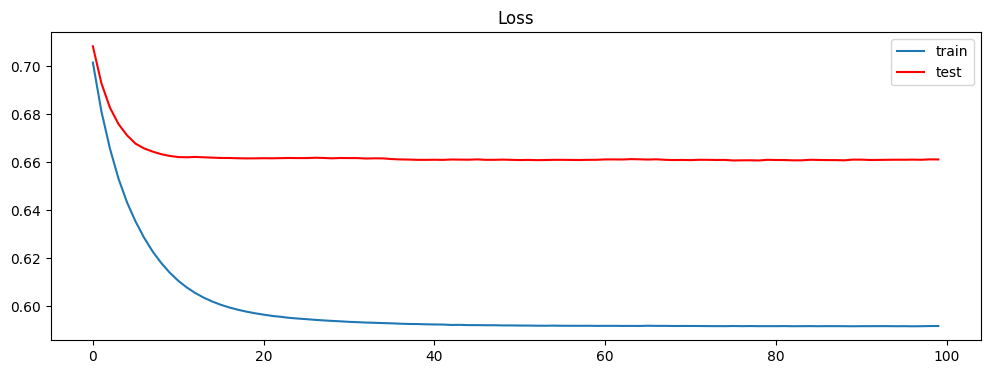

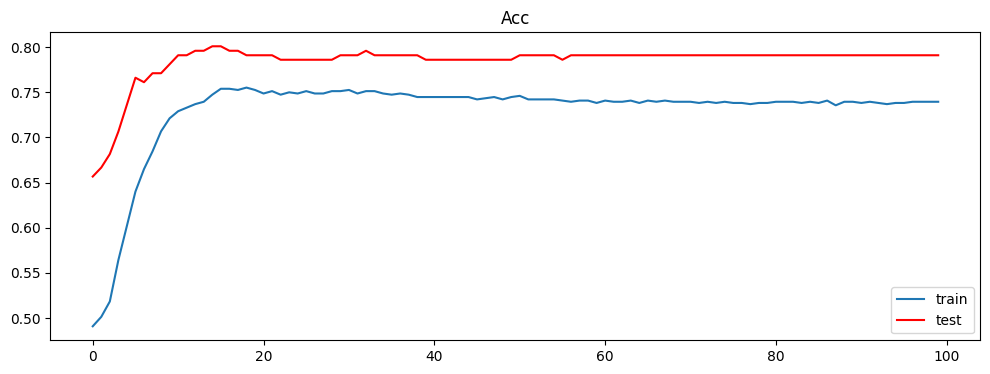

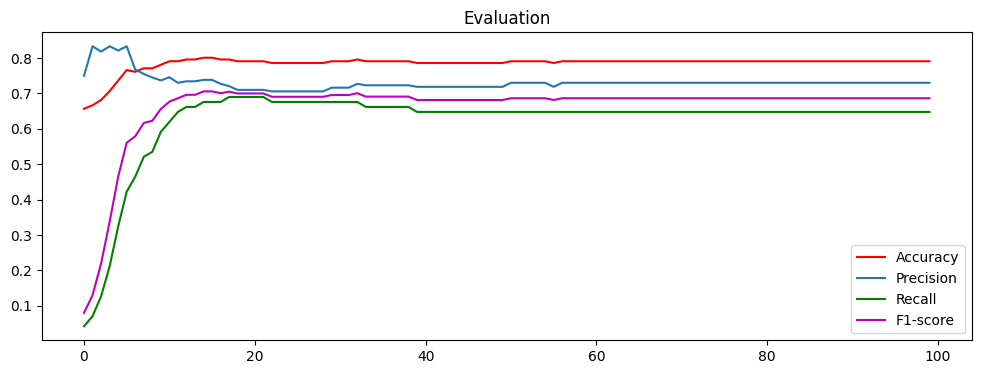

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(test_loss_list)), test_loss_list, c='r')
plt.legend(['train', 'test'])
plt.title('Loss')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(test_acc_list)), test_acc_list, c='r')
plt.legend(['train', 'test'])
plt.title('Acc')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(range(len(test_acc_list)), test_acc_list, c='r')
plt.plot(range(len(test_precision_list)), test_precision_list) 
plt.plot(range(len(test_recall_list)), test_recall_list, c='g')
plt.plot(range(len(test_f1score_list)), test_f1score_list, c='m')
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1-score'])
plt.title('Evaluation')
plt.show()


### 實驗B最好的 epoch

In [27]:
# 找出最高的 acc 以及他的 index
# 之後依據這些 index 去查其他數據
best_test_acc = max(test_acc_list)
best_test_acc_index = test_acc_list.index(best_test_acc)

best_train_acc = train_acc_list[best_test_acc_index]
best_train_loss = train_loss_list[best_test_acc_index]
best_test_loss = test_loss_list[best_test_acc_index]

best_precision = test_precision_list[best_test_acc_index]
best_recall = test_recall_list[best_test_acc_index]
best_f1score = test_f1score_list[best_test_acc_index]

print('=' * 20, 'Epoch', best_test_acc_index, '=' * 20)
print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(best_train_acc, best_train_loss))
print('Test Acc: {:.6f} Test Loss: {:.6f}'.format(best_test_acc, best_test_loss))
print('Test Precision: {:.6f}'.format(best_precision))
print('Test Recall: {:.6f}'.format(best_recall))
print('Test F1-score: {:.6f}'.format(best_f1score))

==================== Epoch 9 ====================
Train Acc: 0.728587 Train Loss: 0.610348
Test Acc: 0.810000 Test Loss: 0.635566
Test Precision: 0.846154
Test Recall: 0.594595
Test F1-score: 0.698413


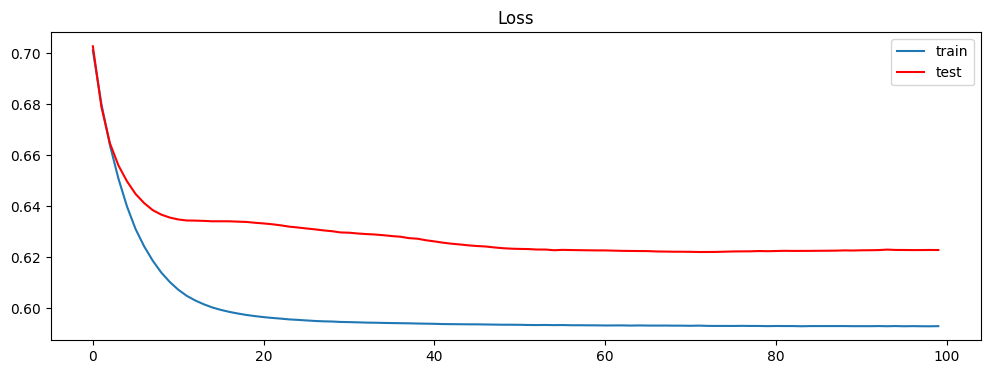

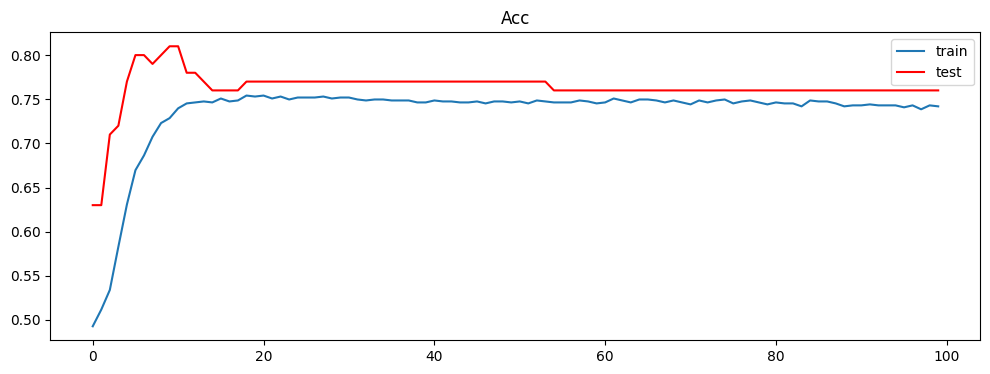

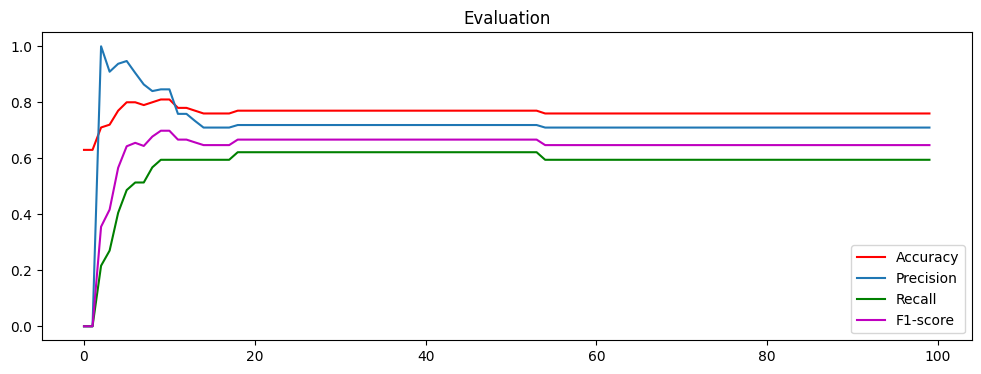

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(test_loss_list)), test_loss_list, c='r')
plt.legend(['train', 'test'])
plt.title('Loss')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(test_acc_list)), test_acc_list, c='r')
plt.legend(['train', 'test'])
plt.title('Acc')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(range(len(test_acc_list)), test_acc_list, c='r')
plt.plot(range(len(test_precision_list)), test_precision_list) 
plt.plot(range(len(test_recall_list)), test_recall_list, c='g')
plt.plot(range(len(test_f1score_list)), test_f1score_list, c='m')
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1-score'])
plt.title('Evaluation')
plt.show()